## Run trained models for qualitative analysis

In [1]:
import logging

logger = logging.getLogger()
logger.disabled = True

import os
from collections import Counter
from copy import deepcopy

from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import numpy as np
import torch
from agent import DQNAgent
from humemai.utils import read_yaml
from humemai.policy import (
    answer_question,
    argmax,
    encode_observation,
    explore,
    manage_memory,
)

root_path = (
    f"trained-results/non-equal-object-probs/dqn/room_size=xl-different-prob/"
    f"capacity=48/2024-07-04 04:19:34.336511"
)


train_params_path = os.path.join(root_path, "train.yaml")
train_params = read_yaml(train_params_path)
train_params["default_root_dir"] = "training-results/TRASH"
train_params["semantic_decay_factor"] = 0.8
num_tests = 20

stats_interest = [
    {
        "mm": {"state": [], "attention": [], "q_value": [], "action": []},
        "explore": {"state": [], "attention": [], "q_value": [], "action": []},
        "hidden_state": None,
        "questions": [],
        "answers": [],
        "score": None,
    }
    for _ in range(num_tests)
]


def process_room_observations(
    agent: DQNAgent, observations_room: list
) -> tuple[list, list, list, list]:
    """Process room observations. This is used when training an exploration policy.

    Args:
        DQNAgent: agent
        observations_room: observations["room"] from the environment

    Returns:
        tuple[list, list, list]: states_all, attention_all, q_values_all, actions_all

    """
    states_all = []
    attention_all = []
    q_values_all = []
    actions_all = []

    for obs in observations_room:
        encode_observation(agent.memory_systems, obs)
        state = agent.memory_systems.return_as_a_dict_list()
        states_all.append(deepcopy(state))
        with torch.no_grad():
            lstm_out, attention = agent.lstm_mm(
                np.array([state]), agent.memory_types["mm"]
            )
            attention = attention.squeeze(0).sum(dim=0).tolist()
            q_values = agent.mlp_mm(lstm_out).detach().cpu().tolist()[0]

            action = argmax(q_values)

            manage_memory(
                memory_systems=agent.memory_systems,
                policy=agent.action2str["mm"][action],
                split_possessive=False,
            )

        attention_all.append(deepcopy(attention))
        q_values_all.append(deepcopy(q_values))
        actions_all.append(deepcopy(action))
    agent.memory_systems.semantic.decay()

    return states_all, attention_all, q_values_all, actions_all


def explore(agent: DQNAgent) -> tuple[list, list, list, list]:
    """Explore the environment using the exploration policy.

    Args:
        DQNAgent: agent

    Returns:
        tuple[dict, list, list]: state, attention, q_values, action

    """
    state = agent.get_deepcopied_memory_state()
    with torch.no_grad():
        lstm_out, attention = agent.lstm_explore(
            np.array([state]), agent.memory_types["explore"]
        )
        attention = attention.squeeze(0).sum(dim=0).tolist()
        q_values = agent.mlp_explore(lstm_out).detach().cpu().tolist()[0]
        action = argmax(q_values)

    return state, attention, q_values, action


def load_models(agent: DQNAgent, root_path: str) -> None:
    """Load models from a given root_path.

    Args:
        DQNAgent: agent
        root_path: root path

    """
    for checkpoint_path in glob(os.path.join(root_path, "*/*/*/*.pt")):
        if "mm" in checkpoint_path and "lstm" in checkpoint_path:
            agent.lstm_mm.load_state_dict(torch.load(checkpoint_path))
            agent.lstm_mm.eval()
            for param in agent.lstm_mm.parameters():
                param.requires_grad = False
        elif "mm" in checkpoint_path and "mlp" in checkpoint_path:
            agent.mlp_mm.load_state_dict(torch.load(checkpoint_path))
            agent.mlp_mm.eval()
            for param in agent.mlp_mm.parameters():
                param.requires_grad = False
        elif "explore" in checkpoint_path and "lstm" in checkpoint_path:
            agent.lstm_explore.load_state_dict(torch.load(checkpoint_path))
            agent.lstm_explore.eval()
            for param in agent.lstm_explore.parameters():
                param.requires_grad = False
        elif "explore" in checkpoint_path and "mlp" in checkpoint_path:
            agent.mlp_explore.load_state_dict(torch.load(checkpoint_path))
            agent.mlp_explore.eval()
            for param in agent.mlp_explore.parameters():
                param.requires_grad = False
        else:
            raise ValueError("Unknown checkpoint path")


for idx in tqdm(range(num_tests)):
    train_params["train_seed"] = idx
    train_params["test_seed"] = idx
    agent = DQNAgent(**train_params)
    load_models(agent, root_path)
    new_episode_starts = True
    score = 0
    while True:
        if new_episode_starts:
            agent.init_memory_systems()
            observations, info = agent.env.reset()
            done = False
            states_all, attention_all, q_values_all, actions_all = (
                process_room_observations(agent, observations["room"])
            )
            stats_interest[idx]["mm"]["state"].extend(deepcopy(states_all))
            stats_interest[idx]["mm"]["attention"].extend(deepcopy(attention_all))
            stats_interest[idx]["mm"]["q_value"].extend(deepcopy(q_values_all))
            stats_interest[idx]["mm"]["action"].extend(deepcopy(actions_all))

            new_episode_starts = False

        else:
            state, attention, q_values, action = explore(agent)
            stats_interest[idx]["explore"]["state"].append(deepcopy(state))
            stats_interest[idx]["explore"]["attention"].append(deepcopy(attention))
            stats_interest[idx]["explore"]["q_value"].append(deepcopy(q_values))
            stats_interest[idx]["explore"]["action"].append(deepcopy(action))

            answers = [
                answer_question(
                    agent.memory_systems,
                    agent.qa_function,
                    q,
                    split_possessive=False,
                )
                for q in observations["questions"]
            ]
            stats_interest[idx]["questions"].extend(deepcopy(observations["questions"]))
            stats_interest[idx]["answers"].extend(deepcopy(answers))

            action_pair = (answers, agent.action2str["explore"][action])
            (
                observations,
                reward,
                done,
                truncated,
                info,
            ) = agent.env.step(action_pair)
            done = done or truncated

            if not done:
                states_all, attention_all, q_values_all, actions_all = (
                    process_room_observations(agent, observations["room"])
                )
                stats_interest[idx]["mm"]["state"].extend(deepcopy(states_all))
                stats_interest[idx]["mm"]["attention"].extend(deepcopy(attention_all))
                stats_interest[idx]["mm"]["q_value"].extend(deepcopy(q_values_all))
                stats_interest[idx]["mm"]["action"].extend(deepcopy(actions_all))

            score += reward

        if done:
            stats_interest[idx]["hidden_state"] = deepcopy(
                agent.env.unwrapped.hidden_global_states_all
            )

            break
    stats_interest[idx]["score"] = score

    agent.remove_results_from_disk()


for idx in range(num_tests):
    print(
        idx,
        ": ",
        stats_interest[idx]["score"],
        "\t",
        Counter(stats_interest[idx]["mm"]["action"]),
        Counter(stats_interest[idx]["explore"]["action"]),
    )

/home/tk/.virtualenvs/agent-room-env-v2-lstm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/20 [00:00<?, ?it/s]/home/tk/.virtualenvs/agent-room-env-v2-lstm/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:168: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
/home/tk/.virtualenvs/agent-room-env-v2-lstm/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/home/tk/.virtualenvs/agent-room-env-v2-

Running on cpu


  5%|▌         | 1/20 [00:05<01:40,  5.27s/it]

Running on cpu


 10%|█         | 2/20 [00:13<02:09,  7.21s/it]

Running on cpu


 15%|█▌        | 3/20 [00:20<01:56,  6.83s/it]

Running on cpu


 20%|██        | 4/20 [00:26<01:48,  6.79s/it]

Running on cpu


 25%|██▌       | 5/20 [00:33<01:40,  6.72s/it]

Running on cpu


 30%|███       | 6/20 [00:38<01:27,  6.22s/it]

Running on cpu


 35%|███▌      | 7/20 [00:43<01:14,  5.70s/it]

Running on cpu


 40%|████      | 8/20 [00:49<01:10,  5.89s/it]

Running on cpu


 45%|████▌     | 9/20 [00:55<01:03,  5.74s/it]

Running on cpu


 50%|█████     | 10/20 [01:01<00:59,  6.00s/it]

Running on cpu


 55%|█████▌    | 11/20 [01:08<00:57,  6.39s/it]

Running on cpu


 60%|██████    | 12/20 [01:15<00:50,  6.32s/it]

Running on cpu


 65%|██████▌   | 13/20 [01:19<00:39,  5.65s/it]

Running on cpu


 70%|███████   | 14/20 [01:21<00:26,  4.50s/it]

Running on cpu


 75%|███████▌  | 15/20 [01:22<00:18,  3.71s/it]

Running on cpu


 80%|████████  | 16/20 [01:25<00:12,  3.23s/it]

Running on cpu


 85%|████████▌ | 17/20 [01:26<00:08,  2.82s/it]

Running on cpu


 90%|█████████ | 18/20 [01:28<00:05,  2.54s/it]

Running on cpu


 95%|█████████▌| 19/20 [01:30<00:02,  2.31s/it]

Running on cpu


100%|██████████| 20/20 [01:32<00:00,  4.63s/it]

0 :  316 	 Counter({1: 511, 0: 39}) Counter({2: 95, 1: 5})
1 :  181 	 Counter({1: 628, 0: 41}) Counter({1: 95, 2: 5})
2 :  214 	 Counter({1: 697, 0: 41}) Counter({1: 95, 2: 5})
3 :  238 	 Counter({1: 469, 0: 46}) Counter({2: 90, 1: 10})
4 :  327 	 Counter({1: 493, 0: 39}) Counter({2: 95, 1: 5})
5 :  258 	 Counter({1: 551, 0: 39}) Counter({1: 96, 2: 4})
6 :  325 	 Counter({1: 482, 0: 39}) Counter({2: 95, 1: 5})
7 :  320 	 Counter({1: 498, 0: 40}) Counter({2: 95, 1: 5})
8 :  209 	 Counter({1: 499, 0: 40}) Counter({1: 96, 2: 4})
9 :  191 	 Counter({1: 521, 0: 37}) Counter({2: 96, 1: 4})
10 :  161 	 Counter({1: 657, 0: 42}) Counter({1: 95, 2: 5})
11 :  361 	 Counter({1: 525, 0: 39}) Counter({2: 95, 1: 5})
12 :  343 	 Counter({1: 529, 0: 39}) Counter({2: 95, 1: 5})
13 :  277 	 Counter({1: 467, 0: 39}) Counter({2: 95, 1: 5})
14 :  283 	 Counter({1: 472, 0: 39}) Counter({2: 95, 1: 5})
15 :  300 	 Counter({1: 484, 0: 41}) Counter({2: 95, 1: 5})
16 :  227 	 Counter({1: 549, 0: 40}) Counter({1: 

### Choose the best index

In [15]:
idx_of_interest = 11

### Last hidden state of the environment

In [16]:
last_hidden_state = [foo for foo in stats_interest[idx_of_interest]["hidden_state"]][-2]
last_hidden_state

[['room_000', 'north', 'wall', 99],
 ['room_000', 'east', 'room_001', 99],
 ['room_000', 'south', 'room_004', 99],
 ['room_000', 'west', 'wall', 99],
 ['room_001', 'north', 'wall', 99],
 ['room_001', 'east', 'wall', 99],
 ['room_001', 'south', 'room_005', 99],
 ['room_001', 'west', 'room_000', 99],
 ['room_002', 'north', 'wall', 99],
 ['room_002', 'east', 'room_003', 99],
 ['room_002', 'south', 'room_008', 99],
 ['room_002', 'west', 'wall', 99],
 ['room_003', 'north', 'wall', 99],
 ['room_003', 'east', 'wall', 99],
 ['room_003', 'south', 'room_009', 99],
 ['room_003', 'west', 'room_002', 99],
 ['room_004', 'north', 'room_000', 99],
 ['room_004', 'east', 'room_005', 99],
 ['room_004', 'south', 'wall', 99],
 ['room_004', 'west', 'wall', 99],
 ['room_005', 'north', 'room_001', 99],
 ['room_005', 'east', 'room_006', 99],
 ['room_005', 'south', 'wall', 99],
 ['room_005', 'west', 'room_004', 99],
 ['room_006', 'north', 'wall', 99],
 ['room_006', 'east', 'room_007', 99],
 ['room_006', 'south'

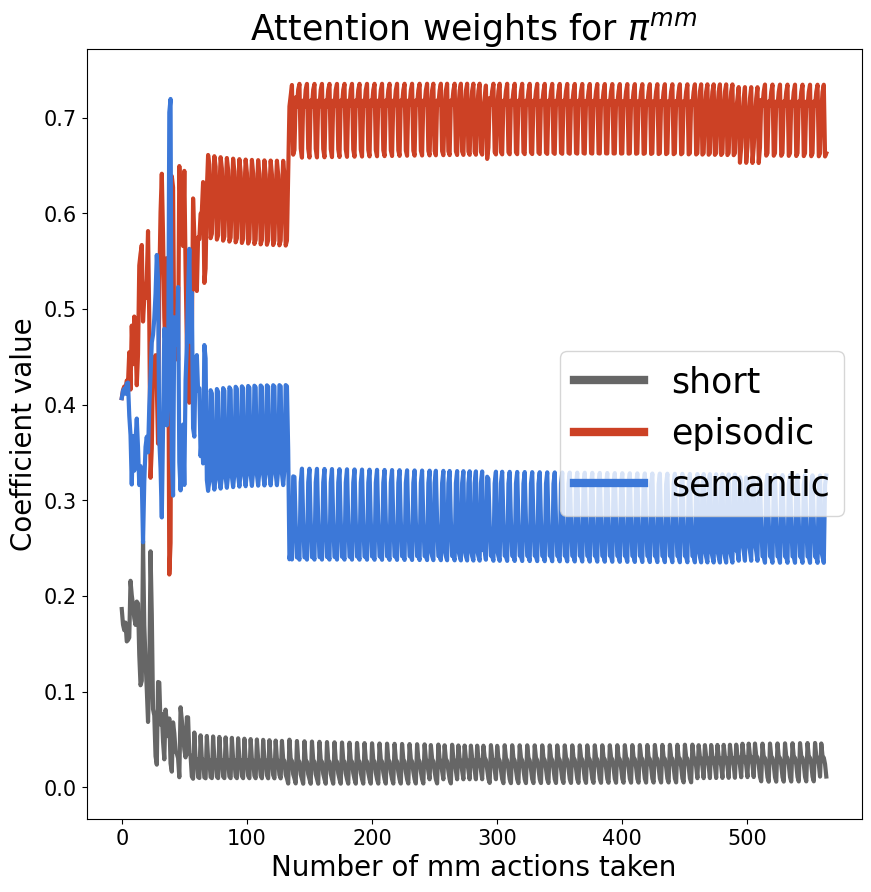

In [17]:
colors = ["#666666ff", "#cc4125ff", "#3c78d8ff"]  # short, episodic, semantic

plt.figure(figsize=(10, 10))
for i in range(len(agent.memory_types["mm"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["mm"]["attention"]],
        label=agent.memory_types["mm"][i],
        color=colors[i],
        linewidth=3.0,
    )

# Create the legend
leg = plt.legend(loc="best", fontsize=25)

# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(6.0)

plt.title("Attention weights for $\pi^{mm}$", fontsize=25)
plt.xlabel("Number of mm actions taken", fontsize=20)
plt.ylabel("Coefficient value", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("attention_weights_mm.pdf")
plt.show()

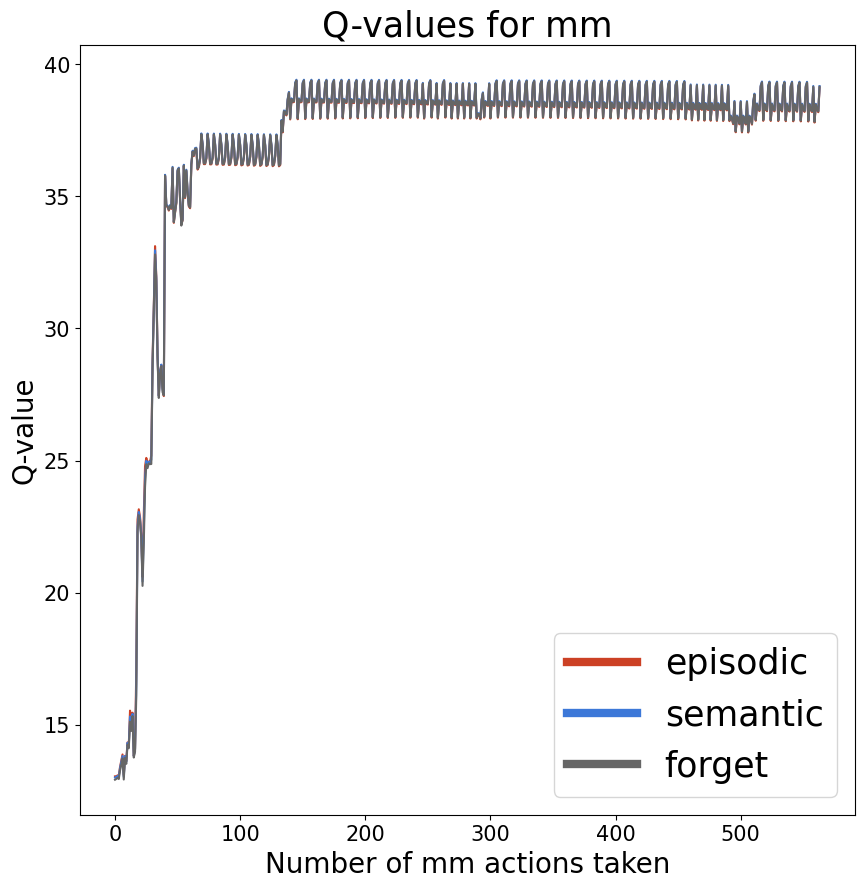

In [18]:
colors = ["#cc4125ff", "#3c78d8ff", "#666666ff"]  # episodic, semantic, forget
plt.figure(figsize=(10, 10))

for i in range(len(agent.action2str["mm"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["mm"]["q_value"]],
        label=agent.action2str["mm"][i],
        color=colors[i],
    )

# Create the legend
leg = plt.legend(loc="best", fontsize=25)

# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(6.0)

# plt.legend(loc="best")
plt.title("Q-values for mm", fontsize=25)
plt.xlabel("Number of mm actions taken", fontsize=20)
plt.ylabel("Q-value", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("q_values_mm.pdf")
plt.show()

### Memory management actions taken

In [19]:
[
    (idx, agent.action2str["mm"][foo])
    for idx, foo in enumerate(stats_interest[idx_of_interest]["mm"]["action"])
]

[(0, 'episodic'),
 (1, 'episodic'),
 (2, 'episodic'),
 (3, 'episodic'),
 (4, 'episodic'),
 (5, 'episodic'),
 (6, 'episodic'),
 (7, 'episodic'),
 (8, 'episodic'),
 (9, 'episodic'),
 (10, 'episodic'),
 (11, 'episodic'),
 (12, 'episodic'),
 (13, 'episodic'),
 (14, 'episodic'),
 (15, 'episodic'),
 (16, 'episodic'),
 (17, 'episodic'),
 (18, 'episodic'),
 (19, 'episodic'),
 (20, 'episodic'),
 (21, 'episodic'),
 (22, 'episodic'),
 (23, 'episodic'),
 (24, 'episodic'),
 (25, 'episodic'),
 (26, 'episodic'),
 (27, 'episodic'),
 (28, 'episodic'),
 (29, 'episodic'),
 (30, 'episodic'),
 (31, 'episodic'),
 (32, 'episodic'),
 (33, 'episodic'),
 (34, 'episodic'),
 (35, 'episodic'),
 (36, 'episodic'),
 (37, 'semantic'),
 (38, 'episodic'),
 (39, 'semantic'),
 (40, 'semantic'),
 (41, 'semantic'),
 (42, 'semantic'),
 (43, 'semantic'),
 (44, 'semantic'),
 (45, 'semantic'),
 (46, 'semantic'),
 (47, 'semantic'),
 (48, 'semantic'),
 (49, 'semantic'),
 (50, 'semantic'),
 (51, 'semantic'),
 (52, 'semantic'),
 (5

### All short-term memories

In [20]:
[
    (idx, len(foo["episodic"]), len(foo["semantic"]), foo)
    for idx, foo in enumerate(stats_interest[idx_of_interest]["mm"]["state"])
]

[(0,
  0,
  0,
  {'episodic': [],
   'semantic': [],
   'short': [['room_000', 'north', 'wall', 0]]}),
 (1,
  1,
  0,
  {'episodic': [['room_000', 'north', 'wall', 0]],
   'semantic': [],
   'short': [['room_000', 'east', 'room_001', 0]]}),
 (2,
  2,
  0,
  {'episodic': [['room_000', 'north', 'wall', 0],
    ['room_000', 'east', 'room_001', 0]],
   'semantic': [],
   'short': [['room_000', 'south', 'room_004', 0]]}),
 (3,
  3,
  0,
  {'episodic': [['room_000', 'north', 'wall', 0],
    ['room_000', 'east', 'room_001', 0],
    ['room_000', 'south', 'room_004', 0]],
   'semantic': [],
   'short': [['room_000', 'west', 'wall', 0]]}),
 (4,
  4,
  0,
  {'episodic': [['room_000', 'north', 'wall', 0],
    ['room_000', 'east', 'room_001', 0],
    ['room_000', 'south', 'room_004', 0],
    ['room_000', 'west', 'wall', 0]],
   'semantic': [],
   'short': [['agent', 'atlocation', 'room_000', 0]]}),
 (5,
  5,
  0,
  {'episodic': [['room_000', 'north', 'wall', 0],
    ['room_000', 'east', 'room_001',

### Agent's locations

In [28]:
visited = []
for idx, foo in enumerate(stats_interest[idx_of_interest]["mm"]["state"]):
    if foo["short"][0][0] == "agent":
        print(f"At time {idx}\t agent at {foo['short'][0][2]}")
        visited.append(foo["short"][0][2])

Counter(visited)

At time 4	 agent at room_000
At time 11	 agent at room_001
At time 16	 agent at room_005
At time 21	 agent at room_006
At time 27	 agent at room_007
At time 33	 agent at room_008
At time 39	 agent at room_009
At time 45	 agent at room_012
At time 51	 agent at room_017
At time 56	 agent at room_021
At time 62	 agent at room_027
At time 67	 agent at room_027
At time 72	 agent at room_027
At time 77	 agent at room_027
At time 82	 agent at room_027
At time 87	 agent at room_027
At time 92	 agent at room_027
At time 97	 agent at room_027
At time 102	 agent at room_027
At time 107	 agent at room_027
At time 112	 agent at room_027
At time 117	 agent at room_027
At time 122	 agent at room_027
At time 127	 agent at room_027
At time 132	 agent at room_027
At time 138	 agent at room_027
At time 144	 agent at room_027
At time 150	 agent at room_027
At time 156	 agent at room_027
At time 162	 agent at room_027
At time 168	 agent at room_027
At time 174	 agent at room_027
At time 180	 agent at room_

Counter({'room_027': 90,
         'room_000': 1,
         'room_001': 1,
         'room_005': 1,
         'room_006': 1,
         'room_007': 1,
         'room_008': 1,
         'room_009': 1,
         'room_012': 1,
         'room_017': 1,
         'room_021': 1})

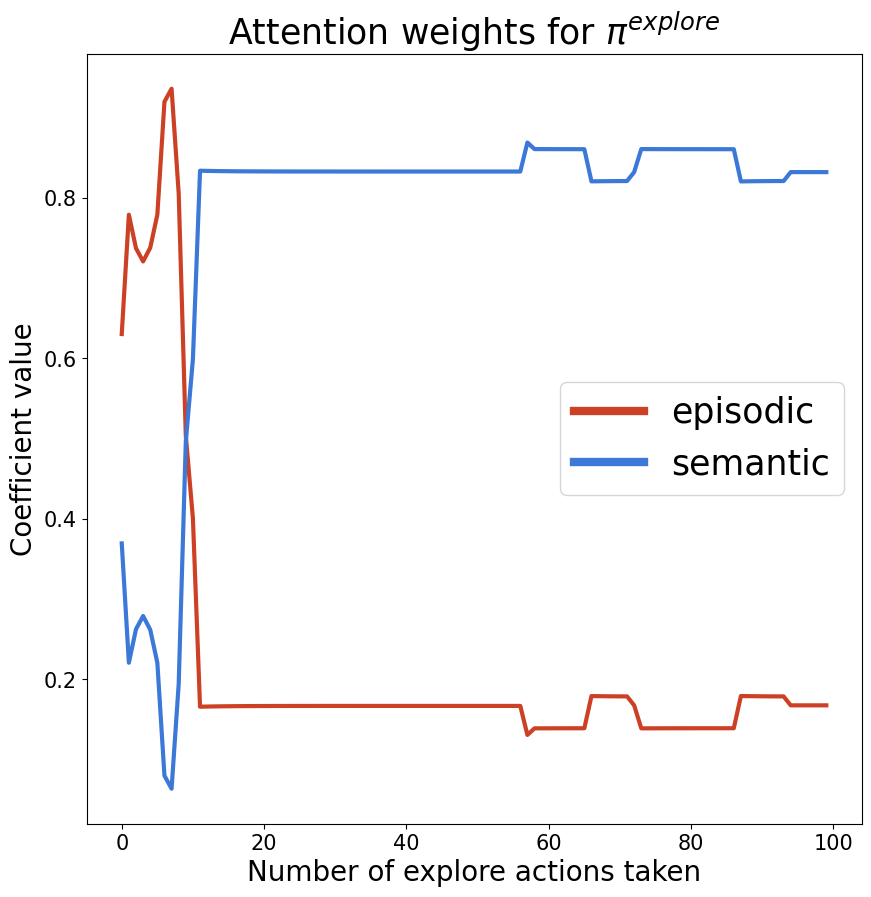

In [9]:
colors = ["#cc4125ff", "#3c78d8ff"]  # episodic, semantic

plt.figure(figsize=(10, 10))

for i in range(len(agent.memory_types["explore"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["explore"]["attention"]],
        label=agent.memory_types["explore"][i],
        linewidth=3.0,
        color=colors[i],
    )

# Create the legend
leg = plt.legend(loc="best", fontsize=25)

# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(6.0)

plt.title("Attention weights for $\pi^{explore}$", fontsize=25)
plt.xlabel("Number of explore actions taken", fontsize=20)
plt.ylabel("Coefficient value", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("attention_weights_explore.pdf")
plt.show()

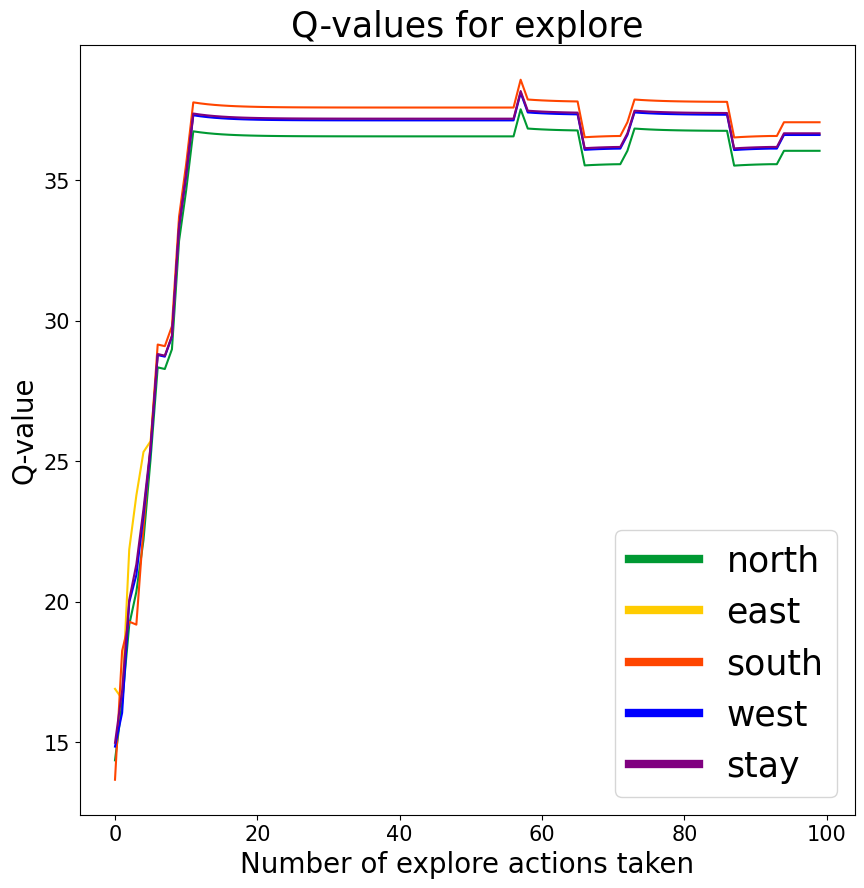

In [10]:
colors = ["#009933", "#ffcc00", "#ff4500", "#0000ff", "#800080"]
plt.figure(figsize=(10, 10))
for i in range(len(agent.action2str["explore"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["explore"]["q_value"]],
        label=agent.action2str["explore"][i],
        color=colors[i],
    )

# Create the legend
leg = plt.legend(loc="best", fontsize=25)

# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(6.0)

# plt.legend(loc="best")
plt.title("Q-values for explore", fontsize=25)
plt.xlabel("Number of explore actions taken", fontsize=20)
plt.ylabel("Q-value", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("q_values_explore.pdf")
plt.show()

### Agents explore actions

In [11]:
[
    (idx, agent.action2str["explore"][foo])
    for idx, foo in enumerate(stats_interest[idx_of_interest]["explore"]["action"])
]

[(0, 'east'),
 (1, 'south'),
 (2, 'east'),
 (3, 'east'),
 (4, 'east'),
 (5, 'east'),
 (6, 'south'),
 (7, 'south'),
 (8, 'south'),
 (9, 'south'),
 (10, 'south'),
 (11, 'south'),
 (12, 'south'),
 (13, 'south'),
 (14, 'south'),
 (15, 'south'),
 (16, 'south'),
 (17, 'south'),
 (18, 'south'),
 (19, 'south'),
 (20, 'south'),
 (21, 'south'),
 (22, 'south'),
 (23, 'south'),
 (24, 'south'),
 (25, 'south'),
 (26, 'south'),
 (27, 'south'),
 (28, 'south'),
 (29, 'south'),
 (30, 'south'),
 (31, 'south'),
 (32, 'south'),
 (33, 'south'),
 (34, 'south'),
 (35, 'south'),
 (36, 'south'),
 (37, 'south'),
 (38, 'south'),
 (39, 'south'),
 (40, 'south'),
 (41, 'south'),
 (42, 'south'),
 (43, 'south'),
 (44, 'south'),
 (45, 'south'),
 (46, 'south'),
 (47, 'south'),
 (48, 'south'),
 (49, 'south'),
 (50, 'south'),
 (51, 'south'),
 (52, 'south'),
 (53, 'south'),
 (54, 'south'),
 (55, 'south'),
 (56, 'south'),
 (57, 'south'),
 (58, 'south'),
 (59, 'south'),
 (60, 'south'),
 (61, 'south'),
 (62, 'south'),
 (63, '

### Questions asked

In [12]:
Counter([str(foo[:-1]) for foo in stats_interest[idx_of_interest]["questions"]])

Counter({"['sta_002', 'atlocation', '?']": 124,
         "['ind_001', 'atlocation', '?']": 119,
         "['dep_002', 'atlocation', '?']": 106,
         "['sta_006', 'atlocation', '?']": 93,
         "['dep_005', 'atlocation', '?']": 89,
         "['sta_005', 'atlocation', '?']": 84,
         "['ind_002', 'atlocation', '?']": 73,
         "['sta_003', 'atlocation', '?']": 63,
         "['sta_004', 'atlocation', '?']": 52,
         "['ind_007', 'atlocation', '?']": 49,
         "['dep_003', 'atlocation', '?']": 29,
         "['dep_007', 'atlocation', '?']": 23,
         "['ind_004', 'atlocation', '?']": 21,
         "['dep_001', 'atlocation', '?']": 17,
         "['ind_005', 'atlocation', '?']": 17,
         "['ind_000', 'atlocation', '?']": 13,
         "['sta_000', 'atlocation', '?']": 9,
         "['ind_006', 'atlocation', '?']": 7,
         "['sta_001', 'atlocation', '?']": 5,
         "['dep_000', 'atlocation', '?']": 3,
         "['dep_006', 'atlocation', '?']": 2,
         "['ind

### Answers

In [13]:
from collections import Counter

Counter([str(foo) for foo in stats_interest[idx_of_interest]["answers"]])

Counter({'none': 530,
         'room_008': 219,
         'room_021': 79,
         'room_017': 66,
         'room_006': 50,
         'room_027': 42,
         'room_009': 7,
         'room_007': 5,
         'room_000': 2})